In [1]:
import numpy as np
import pandas as pd
from metrics import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import seaborn as sns
import plotly_express as px
from scipy.spatial.distance import cdist
from kmeans import *

# Iris dataset

In [2]:
# load the iris dataset
iris_data = load_iris() 
df_data = pd.DataFrame(data= np.c_[iris_data['data'], iris_data['target']],
                     columns= iris_data['feature_names'] + ['target'])
# drop target
df_data = df_data.drop(columns=['target'])

## K-means clustering

In [3]:
centroids,clusters = kmeans_clustering(df_data,3)

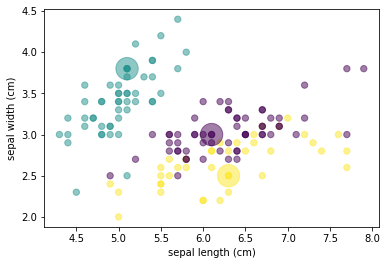

In [5]:
# plot the results
plot_kmeans(df_data, 3, centroids.values, clusters)

## Fuzzy c means clustering

In [12]:
def initial_member_matrix(data: pd.DataFrame, k: int) -> pd.DataFrame:
    '''
    Initialize membership matrix with random values that sum 1
    '''
    membership_matrix = np.random.rand(data.shape[0],k)
    membership_matrix = membership_matrix/np.sum(membership_matrix,axis=1).reshape(-1,1)
    return membership_matrix

def fuzzy_centroids(data: pd.DataFrame, membership_matrix: pd.DataFrame, k: int, m) -> pd.DataFrame:
    """
    Calculate centroids based on the membership matrix
    """
    centroids = np.zeros((k,data.shape[1]))
    for i in range(k):
        accum = 0
        for j in range(data.shape[0]):
            accum += (membership_matrix[j,i]**m)*data.iloc[j,:]
        centroids[i,:] = accum/np.sum(membership_matrix[:,i]**m)
    return centroids

def update_membership(data: pd.DataFrame, centroids: pd.DataFrame, membership_matrix: pd.DataFrame, k: int, m, metric:str = 'euclidean') -> pd.DataFrame:
    """
    Update membership matrix
    """
    distance_matrix = cdist(data,centroids,metric)
    new_membership = np.zeros((data.shape[0],k))
    for i in range(k):
        accum = 0
        for j in range(k):
            accum += (distance_matrix[:,i]/distance_matrix[:,j])**(2/(m-1))
        new_membership[:,i] = 1/accum
    return new_membership

def fuzzy_clustering(data: pd.DataFrame, k: int, m, metric: str = 'euclidean'):
    """
    Fuzzy c-means clustering algorithm
    """
    # initialize membership matrix
    membership_matrix = initial_member_matrix(data, k)
    # initialize bookkeeping vars
    old_membership = membership_matrix
    # run the main fuzzy c-means algorithm
    centroids = fuzzy_centroids(data, membership_matrix, k, m)
    membership_matrix = update_membership(data, centroids, membership_matrix, k, m, metric)
    while not np.all(old_membership == membership_matrix):
        # save old membership for convergence test
        old_membership = membership_matrix
        # update centroids
        centroids = fuzzy_centroids(data, membership_matrix, k, m)
        # update membership
        membership_matrix = update_membership(data, centroids, membership_matrix, k, m, metric)
    return centroids, membership_matrix

def plot_fuzzy_cmeans(X, k, centroids, U):
    #Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(U, axis=1), s=40)
    #Plot the centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', c=np.arange(k), s=500)
    plt.show()


In [13]:
centroids, membership_matrix = fuzzy_clustering(df_data, 3, 2)
plot_fuzzy_cmeans(df_data.values, 3, centroids, membership_matrix)


KeyboardInterrupt: 